In [1]:
import matplotlib.backends
import torch
import xarray as xr
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import cartopy.crs as ccrs 
import matplotlib 
from tqdm.notebook import tqdm
from models.model import CNNQuantilesClassifier, CNNQuantilesClassifierDepthWise
from models.data import load_output_data, load_input_data, get_rain_bool, xarray_to_dataloaders
from models.training import train_loop, eval_loop, evaluate_model

from captum.attr import Occlusion, IntegratedGradients


matplotlib.use('TkAgg')
plt.style.use('robin')

# Load data


In [2]:
%matplotlib inline

In [3]:

learning_rate = 0.001
batch_size = 128
num_epochs = 20
device = 'cuda:0'

ds_ml= xr.open_dataset('/Data/gfi/users/rogui7909/era5_rain_norge/DL_era5_rain_regression_in_out.nc').sel(mask_id=[14]).sel(time=slice(None,'2021'))
ds_ml = ds_ml.where(ds_ml.data_in.count(['longitude', 'latitude']).sum('var_name')==24576, drop=True)
ds_lags = xr.concat([ds_ml.data_in,
                     ds_ml.data_in.shift(time=-1).assign_coords(var_name=['u850l1','v850l1','z500l1']),
                     ds_ml.data_in.shift(time=-2).assign_coords(var_name=['u850l2','v850l2','z500l2']),
                     ds_ml.data_in.shift(time=-3).assign_coords(var_name=['u850l3','v850l3','z500l3'])], 
                               dim='var_name')
ds_ml = xr.Dataset(dict(data_in=ds_lags, data_out=ds_ml.data_out))
ds_ml = ds_ml.isel(time=slice(None, -3))

ds_ml['data_out'] = (ds_ml.data_out.rank('time', pct=True)//.1).astype(int)
time = ds_ml.time 
# time_winter = time.where(time.dt.month.isin([12,1,2]), drop=True)
# ds_ml = ds_ml.sel(time=time_winter)
# ds_ml['data_out'] = ds_ml.data_out.where(ds_ml.data_out>0,0)

# ds_ml['data_out'] = np.log(1e-5+ds_ml.data_out)
# ds_ml_mean = ds_ml.mean(['time','longitude','latitude'])
# ds_ml_std = ds_ml.std(['time','longitude','latitude'])
# ds_ml_standard = (ds_ml-ds_ml_mean)/ds_ml_std

# ds_out = xr.open_dataset('/Data/gfi/users/rogui7909/era5_rain_norge/era5_daily_rainfall_data_290125.nc').total_precipitation_day

# Make tensors


shuffle=True
split = .8
indices = np.arange(ds_ml.time.size)
if shuffle:
    np.random.shuffle(indices)
split = int(split*ds_ml.time.size)
indices_train, indices_test = indices[:split], indices[split:]

ds_train = ds_ml.isel(time=indices_train)
ds_test = ds_ml.isel(time=indices_test)


X_train = torch.tensor(ds_train.data_in.values).type(torch.float32)
X_test = torch.tensor(ds_test.data_in.values).type(torch.float32)
y_train = torch.tensor(ds_train.data_out.values[:,0]).type(torch.long)
y_test = torch.tensor(ds_test.data_out.values[:,0]).type(torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=True)


# Make dataloader
print('Data ready')


Data ready


In [4]:


class LeNET(nn.Module):
    def __init__(self, quantiles,num_channels_in, image_size, groups=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels_in, out_channels=12, kernel_size=3, stride=1, padding=1, groups=3)
        self.bn1 = nn.BatchNorm2d(12)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(24)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        cnn_channels = 24
        max_pools = 4*4
        self.linear_size = image_size * cnn_channels // max_pools 
        self.fc1 = nn.Linear(self.linear_size, 128)
        self.fc2 = nn.Linear(128, quantiles)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.pool1(x)

        x = nn.Dropout()(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)

        x = x.view((-1,self.linear_size))
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return nn.ReLU()(x)
    
class Wang2024(nn.Module):
    def __init__(self, num_classes, image_size, num_channels_in=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels_in, out_channels=12, kernel_size=3, stride=1, padding=1, groups=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=48, kernel_size=3, stride=1, padding=1, groups=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        cnn_channels = 48
        max_pools = 4*4
        self.linear_size = image_size * cnn_channels // max_pools 
        self.fc1 = nn.Linear(self.linear_size, 96)
        self.fc2 = nn.Linear(96, 48)
        self.fc3 = nn.Linear(48, num_classes)

    def forward(self, x):
        # print(x)
        x = self.conv1(x)
        x = nn.ReLU()(x)
        # print(x)
        x = self.pool1(x)
        # print(x)
        x = self.conv2(x)
        # print(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)
        # print(x)
        x = x.view((-1,self.linear_size))
        # print(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = nn.Dropout()(x)

        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = nn.Dropout()(x)

        x = self.fc3(x)
        # x = nn.ReLU()(x)
        
        return x
    


def train_loop(model, train_loader, loss_fn, optimizer, device):
    model.train()
    for X_, y_ in (train_loader):
        X_ = X_.to(device)
        y_ = y_.to(device)
        pred = model(X_)
        loss = loss_fn(pred, y_)
        X_ = X_.cpu()
        y_ = y_.cpu()
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def eval_loop(model, test_loader, loss_fn, device):
    model.eval()
    all_pred = []
    all_y = []
    with torch.no_grad():
        for X_, y_ in test_loader:
            X_ = X_.to(device)
            y_ = y_.to(device)
            pred = model(X_)
            all_pred.append(pred)
            all_y.append(y_)
        pred = torch.cat(all_pred)
        y_ = torch.cat(all_y)
        loss = loss_fn(pred, y_)
    return loss.cpu()


class DistribLoss(nn.Module):
    def __init__(self):
        """
        Initialize the quantile loss module.
        :param quantile: The quantile to estimate (e.g., 0.5 for median, 0.95 for 95th percentile).
        """
        super(DistribLoss, self).__init__()

    def forward(self, predictions, targets):
        """
        Compute the quantile loss.
        :param predictions: Predicted values (torch.Tensor).
        :param targets: Ground truth values (torch.Tensor).
        :return: The quantile loss (torch.Tensor).
        """
        # errors = targets - predictions
        # loss = torch.maximum(
        #     self.quantile * errors,
        #     (self.quantile - 1) * errors
        # )
        targets_sorted, _ = torch.sort(targets)
        predictions_sorted, _ = torch.sort(predictions)
        errors_cdf = torch.abs(targets_sorted - predictions_sorted)[batch_size//2:]**2
        errors = torch.abs(targets - predictions)**2
        loss = torch.mean(errors_cdf) + torch.mean(errors)
        return loss.mean()

class QuantileLoss(nn.Module):
    def __init__(self, quantile):
        """
        Initialize the quantile loss module.
        :param quantile: The quantile to estimate (e.g., 0.5 for median, 0.95 for 95th percentile).
        """
        super(QuantileLoss, self).__init__()
        self.quantile = quantile

    def forward(self, predictions, targets):
        """
        Compute the quantile loss.
        :param predictions: Predicted values (torch.Tensor).
        :param targets: Ground truth values (torch.Tensor).
        :return: The quantile loss (torch.Tensor).
        """
        errors = targets - predictions
        loss = torch.maximum(
            self.quantile * errors,
            (self.quantile - 1) * errors
        )
      
        return loss.mean()


In [6]:

distrib_loss = DistribLoss()
quant_loss = QuantileLoss(0.95)


torch.manual_seed(12)
torch.use_deterministic_algorithms(False)


model = Wang2024(num_classes=10, num_channels_in=12, image_size=128*64).to(device)


loss_fn = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = []
for epoch in range(num_epochs):
    train_loop(model, train_loader, loss_fn, optimizer, device)
    loss_train = eval_loop(model, train_loader, loss_fn, device)
    loss_test = eval_loop(model, test_loader, loss_fn, device)
    print(f'Epoch {epoch+1}:    train loss = {loss_train:>8.02f}    test loss = {loss_test:>8.02f}')
    history.append([loss_train, loss_test])
    # if epoch == num_epochs//2:
    #     loss_fn = distrib_loss.to(device)
history = np.array(history)

Epoch 1:    train loss =     2.29    test loss =     2.29
Epoch 2:    train loss =     2.06    test loss =     2.08
Epoch 3:    train loss =     1.94    test loss =     1.97
Epoch 4:    train loss =     1.87    test loss =     1.91
Epoch 5:    train loss =     1.80    test loss =     1.87
Epoch 6:    train loss =     1.76    test loss =     1.84
Epoch 7:    train loss =     1.76    test loss =     1.87
Epoch 8:    train loss =     1.72    test loss =     1.84
Epoch 9:    train loss =     1.68    test loss =     1.82
Epoch 10:    train loss =     1.64    test loss =     1.81
Epoch 11:    train loss =     1.65    test loss =     1.81
Epoch 12:    train loss =     1.62    test loss =     1.83
Epoch 13:    train loss =     1.58    test loss =     1.83
Epoch 14:    train loss =     1.57    test loss =     1.82
Epoch 15:    train loss =     1.54    test loss =     1.88
Epoch 16:    train loss =     1.52    test loss =     1.86
Epoch 17:    train loss =     1.52    test loss =     1.94
Epoch 

In [7]:
model.eval()
with torch.no_grad():
    model = model.cpu()
    data_in = ds_test.data_in.values.squeeze()
    X = torch.tensor(data_in).type(torch.float32)
    pred = torch.softmax(model(X), dim=1).detach().numpy()

    pred_ds = xr.DataArray(pred, dims = ['time','quantile'], coords=dict(time=ds_test.time, quantile=np.arange(0,10)))
    ds_eval = xr.Dataset(dict(truth=ds_test.data_out.squeeze(), pred_proba=pred_ds, pred=pred_ds.idxmax('quantile'))).sortby('time')


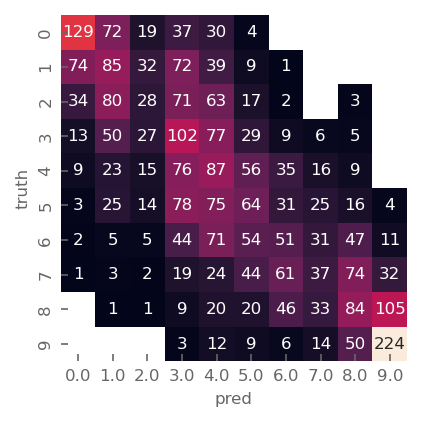

In [8]:
df_ = ds_eval[['truth','pred']].to_dataframe()

sns.heatmap(df_.groupby(['truth','pred']).count().unstack().mask_id,
            square=True, cbar=False, annot=True, fmt = '.0f')


sorted_df_ = df_.transform(np.sort)
# sorted_df_.plot.scatter(y='pred',x='truth', ax=axs[1], s=5, color='.5', zorder=100)


In [9]:
torch.save(model.state_dict(), 'trained_models/wang2024_ERA5_norwaeyW_precip_10quantiles_lag0123.torch')


In [14]:
# device = 'cuda'

loss_fn(model(X_train[:1].to(device)), torch.Tensor([3]).type(torch.long).to(device))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
